Jieyi Yao, Foster Lockerbie

## Importing + Data Preprocessing

In [17]:
import glob
import json
import pandas as pd
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
from transformers import pipeline

In [18]:
file_pattern = "DevGPT/snapshot_*/**/*_issue_sharings.json"

file_paths = glob.glob(file_pattern, recursive=True)

combined_dfs = []

# Loop through each file and process
for file_path in file_paths:
    try:
        # Load JSON file
        with open(file_path, 'r') as file:
            data = json.load(file)
        
        # Flatten the JSON structure
        df = pd.json_normalize(
            data["Sources"],
            record_path=["ChatgptSharing"],  # Path to nested data
            meta=["Author"],  # Include top-level metadata
            sep="_"
        )
        
        # Convert date columns to datetime
        df['DateOfConversation'] = pd.to_datetime(df.get('DateOfConversation'), errors='coerce')
        df['DateOfAccess'] = pd.to_datetime(df.get('DateOfAccess'), errors='coerce')
        
        # Handle missing values in 'Title'
        df['Title'] = df['Title'].fillna('Unknown')
        
        # Classify issues based on 'Title'
        df['IssueType'] = df['Title'].apply(classify_issue)
        
        # Save individual file results as CSV
        output_file = file_path.replace(".json", ".csv")
        df.to_csv(output_file, index=False)
        print(f"Processed and saved: {output_file}")
        
        # Optionally store the DataFrame for later merging
        combined_dfs.append(df)
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Optional: Combine all DataFrames into one
if combined_dfs:
    combined_data = pd.concat(combined_dfs, ignore_index=True)
    combined_data.to_csv("combined_issue_sharings.csv", index=False)
    print("All files combined and saved as combined_issue_sharings.csv")

Error processing file DevGPT/snapshot_20230824/20230824_101836_issue_sharings.json: name 'classify_issue' is not defined
Error processing file DevGPT/snapshot_20230831/20230831_061759_issue_sharings.json: name 'classify_issue' is not defined
Error processing file DevGPT/snapshot_20230727/20230727_195941_issue_sharings.json: name 'classify_issue' is not defined
Error processing file DevGPT/snapshot_20230810/20230810_123938_issue_sharings.json: name 'classify_issue' is not defined
Error processing file DevGPT/snapshot_20230817/20230817_130502_issue_sharings.json: name 'classify_issue' is not defined
Error processing file DevGPT/snapshot_20230803/20230803_094705_issue_sharings.json: name 'classify_issue' is not defined


In [19]:
df = pd.read_csv('combined_issue_sharings.csv')
df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'], errors='coerce')
df['DateOfAccess'] = pd.to_datetime(df['DateOfAccess'], errors='coerce')
df.fillna({'Title': 'No Title', 'HTMLContent': ''}, inplace=True)
df['TokenEfficiency'] = df['TokensOfAnswers'] / df['TokensOfPrompts']

df.to_csv('cleaned_data.csv', index=False)

In [20]:
df = pd.read_csv('cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        2089 non-null   object 
 1   Status                     2089 non-null   int64  
 2   DateOfConversation         1797 non-null   object 
 3   DateOfAccess               1896 non-null   object 
 4   Title                      2089 non-null   object 
 5   NumberOfPrompts            1896 non-null   float64
 6   TokensOfPrompts            1896 non-null   float64
 7   TokensOfAnswers            1896 non-null   float64
 8   Model                      1632 non-null   object 
 9   Conversations              1896 non-null   object 
 10  HTMLContent                1896 non-null   object 
 11  Mention_MentionedURL       2089 non-null   object 
 12  Mention_MentionedProperty  2089 non-null   object 
 13  Mention_MentionedAuthor    2089 non-null   objec

In [21]:
'''categories = {
    'Bug': ['bug', 'error', 'issue', 'fix'],
    'Feature Request': ['feature', 'request', 'implement', 'add'],
    'Theoretical Question': ['theoretical', 'concept', 'explain', 'understand'],
    'Optimization': ['optimize', 'performance', 'improve', 'efficient']
}

def classify_issue(title):
    for category, keywords in categories.items():
        if any(keyword.lower() in title.lower() for keyword in keywords):
            return category
    return 'Other'

df['IssueType'] = df['Title'].apply(classify_issue)


print(df['IssueType'].value_counts())'''

"categories = {\n    'Bug': ['bug', 'error', 'issue', 'fix'],\n    'Feature Request': ['feature', 'request', 'implement', 'add'],\n    'Theoretical Question': ['theoretical', 'concept', 'explain', 'understand'],\n    'Optimization': ['optimize', 'performance', 'improve', 'efficient']\n}\n\ndef classify_issue(title):\n    for category, keywords in categories.items():\n        if any(keyword.lower() in title.lower() for keyword in keywords):\n            return category\n    return 'Other'\n\ndf['IssueType'] = df['Title'].apply(classify_issue)\n\n\nprint(df['IssueType'].value_counts())"

In [6]:
'''
issue_counts = df['IssueType'].value_counts()
print(issue_counts)

import matplotlib.pyplot as plt

issue_counts.plot(kind='bar', title='Types of Issues')
plt.xlabel('Issue Type')
plt.ylabel('Count')
plt.show()
'''

"\nissue_counts = df['IssueType'].value_counts()\nprint(issue_counts)\n\nimport matplotlib.pyplot as plt\n\nissue_counts.plot(kind='bar', title='Types of Issues')\nplt.xlabel('Issue Type')\nplt.ylabel('Count')\nplt.show()\n"

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Replace NaN values with an empty string
df['Conversations'] = df['Conversations'].fillna("")

# Ensure all entries in the column are strings
df['Conversations'] = df['Conversations'].astype(str)

# Extract keywords using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
keywords_matrix = vectorizer.fit_transform(df['Conversations'])

# Get feature names (keywords)
keywords = vectorizer.get_feature_names_out()

# Print extracted keywords
print("Top keywords:", keywords)
pd.DataFrame({"Keywords": keywords}).to_csv("keywords.csv", index=False)

Top keywords: ['answer' 'code' 'code_block_0' 'content' 'data' 'div' 'file' 'id'
 'listofcode' 'model' 'prompt' 'py' 'python' 'replacestring' 'response'
 'return' 'self' 'type' 'use' 'using']


In [24]:
token_summary = df.groupby('IssueType')[['TokensOfPrompts', 'TokensOfAnswers']].mean()
print(token_summary)

                      TokensOfPrompts  TokensOfAnswers
IssueType                                             
Bug                        974.807107      1584.360406
Feature Request           2120.270270      2741.810811
Optimization               604.652174       550.608696
Other                      685.992424      1808.469066
Theoretical Question      1248.333333      3251.000000


In [25]:
language_patterns = {
    'Python': r'\bdef\b|\bimport\b|\bprint\(',
    'JavaScript': r'\bfunction\b|\bvar\b|\blet\b|\bconsole\.log\(',
    'Java': r'\bpublic class\b|\bSystem\.out\.println\b',
    'HTML': r'<html>|<head>|<body>',
    'CSS': r'\{|\bcolor:\b|\bfont-size\b',
    'SQL': r'\bSELECT\b|\bFROM\b|\bWHERE\b'
}

# Function to detect language
def detect_language(code_snippet):
    for language, pattern in language_patterns.items():
        if re.search(pattern, code_snippet, re.IGNORECASE):
            return language
    return 'Unknown'

# Combine code snippets from relevant columns
code_snippets = df['HTMLContent'].dropna().tolist() + df['Conversations'].dropna().tolist()

# Detect languages
detected_languages = [detect_language(snippet) for snippet in code_snippets]

# Count occurrences of each language
language_counts = Counter(detected_languages)

# Display results
print("Language usage:")
for language, count in language_counts.items():
    print(f"{language}: {count}")

Language usage:
JavaScript: 1854
Python: 1297
Java: 34
CSS: 605
Unknown: 193
HTML: 2


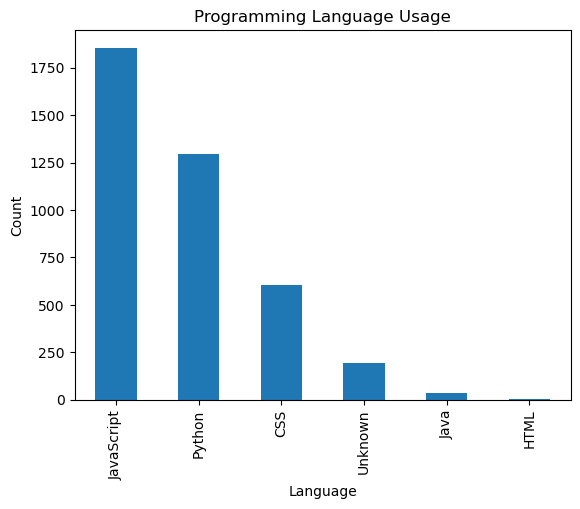

In [26]:

# Convert language counts to DataFrame
language_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count'])

# Plot bar chart
language_df.sort_values('Count', ascending=False).plot(
    kind='bar', x='Language', y='Count', legend=False, title='Programming Language Usage'
)
plt.ylabel('Count')
plt.show()

In [27]:
nlp = spacy.load("en_core_web_sm")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        2089 non-null   object 
 1   Status                     2089 non-null   int64  
 2   DateOfConversation         1797 non-null   object 
 3   DateOfAccess               1896 non-null   object 
 4   Title                      2089 non-null   object 
 5   NumberOfPrompts            1896 non-null   float64
 6   TokensOfPrompts            1896 non-null   float64
 7   TokensOfAnswers            1896 non-null   float64
 8   Model                      1632 non-null   object 
 9   Conversations              2089 non-null   object 
 10  HTMLContent                1896 non-null   object 
 11  Mention_MentionedURL       2089 non-null   object 
 12  Mention_MentionedProperty  2089 non-null   object 
 13  Mention_MentionedAuthor    2089 non-null   objec

In [28]:
fill_mask = pipeline("fill-mask", model="bert-base-uncased", framework="pt")

print("Pipeline loaded successfully!")

categories = {
    'Bug': ['bug', 'error', 'issue', 'fix'],
    'Feature Request': ['feature', 'request', 'implement', 'add'],
    'Theoretical Question': ['theoretical', 'concept', 'explain', 'understand'],
    'Optimization': ['optimize', 'performance', 'improve', 'efficient']
}


def expand_keywords_huggingface(keyword_list, top_n=3):
    expanded_keywords = set(keyword_list)
    for keyword in keyword_list:
        results = fill_mask(f"The {keyword} is very [MASK].")
        for result in results[:top_n]:
            expanded_keywords.add(result['token_str'])
    return list(expanded_keywords)

expanded_categories = {
    category: expand_keywords_huggingface(keywords)
    for category, keywords in categories.items()
}
df_expanded_categories = pd.DataFrame.from_dict(expanded_categories, orient='index').transpose()

csv_file_path = "expanded_categories.csv"
df_expanded_categories.to_csv(csv_file_path, index=False)

print(f"Expanded categories saved to {csv_file_path}")
for category, keywords in expanded_categories.items():
    print(f"{category}: {keywords}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


Pipeline loaded successfully!
Expanded categories saved to expanded_categories.csv
Bug: ['issue', 'high', 'important', 'simple', 'bug', 'small', 'difficult', 'fix', 'serious', 'sensitive', 'rare', 'variable', 'complicated', 'large', 'common', 'error']
Feature Request: ['specific', 'simple', 'unusual', 'fast', 'short', 'request', 'clear', 'rare', 'distinctive', 'implement', 'add', 'efficient', 'feature']
Theoretical Question: ['detailed', 'simple', 'good', 'clear', 'explain', 'concept', 'complicated', 'basic', 'complex', 'understand', 'theoretical']
Optimization: ['simple', 'fast', 'good', 'optimize', 'small', 'improve', 'excellent', 'performance', 'impressive', 'efficient']


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        2089 non-null   object 
 1   Status                     2089 non-null   int64  
 2   DateOfConversation         1797 non-null   object 
 3   DateOfAccess               1896 non-null   object 
 4   Title                      2089 non-null   object 
 5   NumberOfPrompts            1896 non-null   float64
 6   TokensOfPrompts            1896 non-null   float64
 7   TokensOfAnswers            1896 non-null   float64
 8   Model                      1632 non-null   object 
 9   Conversations              2089 non-null   object 
 10  HTMLContent                1896 non-null   object 
 11  Mention_MentionedURL       2089 non-null   object 
 12  Mention_MentionedProperty  2089 non-null   object 
 13  Mention_MentionedAuthor    2089 non-null   objec

In [30]:
keyword_to_category = {keyword: category for category, keywords in expanded_categories.items() for keyword in keywords}

if 'Conversations' in df.columns:
    # Replace NaN with empty strings and ensure all values are strings
    text_column = df['Conversations'].fillna("").astype(str)
else:
    raise ValueError("CSV does not contain a 'Conversations' column.")

# Parameters for chunking
chunk_size = 1000  # Process 1000 rows at a time
counter = 0        # Initialize a counter
categories_detected = [] 

# Process the text in chunks
for i in range(0, len(text_column), chunk_size):
    # Select the current chunk
    chunk = text_column[i:i + chunk_size]
    
    # Use multi-threading with nlp.pipe
    docs = list(nlp.pipe(chunk, n_process=-1, batch_size=100))
    
    for doc in docs:
        # Cleaned tokens: lowercase, no stopwords, no spaces, only alphabetic tokens
        cleaned_tokens = [
            t.lower_ for t in doc
            if not t.is_stop and not t.is_space and t.is_alpha
        ]
        
        matched_categories = {keyword_to_category[token] for token in cleaned_tokens if token in keyword_to_category}
        
        categories_detected.append(", ".join(matched_categories) if matched_categories else "Other")
        
        # Increment the counter
        counter += 1
        
        # Print progress every 100 iterations
        if counter % 100 == 0:
            print(f"Processed {counter} texts. Latest categories: {categories_detected[-1]}")

df['DetectedCategories'] = categories_detected

# Final print statement
print(f"Completed processing {counter} texts!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

DetectedCategories
Other                                                       517
Optimization, Feature Request, Bug, Theoretical Question    409
Feature Request                                             204
Feature Request, Bug                                        190
Feature Request, Bug, Theoretical Question                  173
Bug                                                         141
Optimization, Feature Request, Bug                          132
Optimization                                                 48
Bug, Theoretical Question                                    47
Feature Request, Theoretical Question                        45
Optimization, Bug, Theoretical Question                      44
Theoretical Question                                         43
Optimization, Feature Request                                43
Optimization, Feature Request, Theoretical Question          30
Optimization, Bug                                            23
Name: count, dtype: i

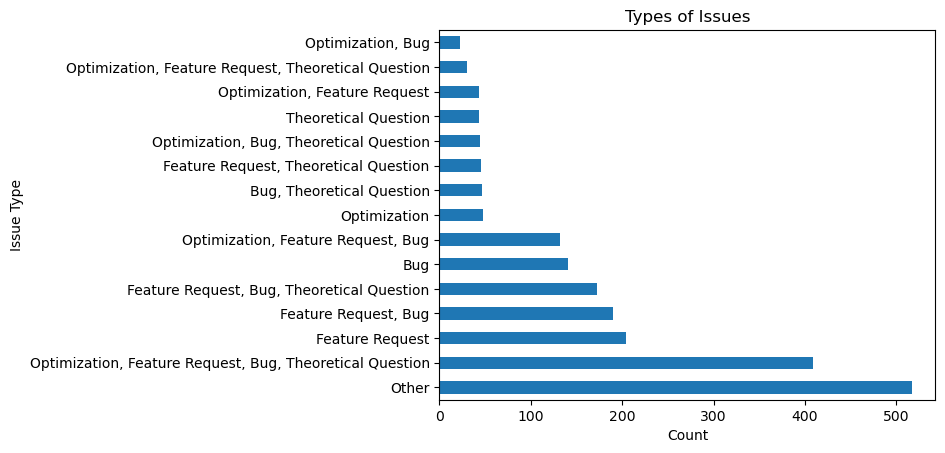

In [ ]:
issue_counts = df['DetectedCategories'].value_counts()
print(issue_counts)

issue_counts.plot(kind='barh', title='Types of Issues')
plt.ylabel('Issue Type')
plt.xlabel('Count')
plt.show()